# Computational Physics project
--by Hui Kong

--kong.291@osu.edu

In the project I look into a program called fastPM, where PM stands for particle mesh. Particle mesh is an efficient method to calculate the density field as well as the gravitational field solved by the gravitational possion equation. It can help us better understand how the system envolve with time. 

The dataset I used for this project are from eBoss ELG(Emission Line Galaxies) catalogue. These set of galaxies are in redshift 0.7-1.0, with strong OII doublet emission. For this project, I will first select a certain cubic volume which is roughly complete and has data everywhere. Then I will convert the galaxies in this volume into a 'mesh', a 20$*$20$*$20 density field. Using this mesh field, I can calculate the power spectrum. The output power spectrum will then be an input to fastPM, I will use this power spectrum to generate a lot more mock galaxies. I can also generate galaxies and galaxy mesh at higher redshift. e.g, at redshit=1.4, which will be the targets for next generation galaxy surveys (like DESI, Dark Energy Spectroscopic Instrument). This will help us pre-determine how the ELGs look like at higher redshifts. 

### open the file

In [2]:
import astropy.io.fits as fits
dat = fits.open('/global/homes/h/huikong/eboss/ELG_Data/elg_240_sgc.v2.clustering.chunk21.fits')[1].data

### show column names of the file

In [3]:
dat.columns

ColDefs(
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'z'; format = 'D'
    name = 'w'; format = 'D'
    name = 'ra_err'; format = 'D'
    name = 'dec_err'; format = 'D'
    name = 'z_err'; format = 'D'
    name = 'w_err'; format = 'D'
)

### Show the footprint of data

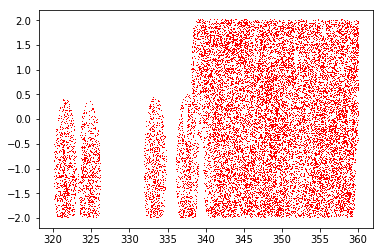

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(dat['ra'],dat['dec'],'r,')

# select valid z

In [5]:
SELECTION_z = dat['z']
SELECTION = (SELECTION_z>0.7) & (SELECTION_z<1.0)
dat_goodz = dat[SELECTION]

# Using nbodykit to get the Power Spectrum
load the modules needed

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from nbodykit.lab import *
from nbodykit import setup_logging, style
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
plt.style.use(style.notebook)
setup_logging()

/global/homes/h/huikong/.conda/envs/cfastpm/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Convert ra,dec,z to x,y,z

In [8]:
dat_ra = dat_goodz['ra']
dat_dec = dat_goodz['dec']
dat_z = dat_goodz['z']
w = 1./dat_goodz['w']
#cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.31)
#Position = transform.SkyToCartesian(ra, dec, z, cosmo=cosmo)
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
dat_distance = cosmo.comoving_distance(dat_z)
from astropy import units as u
from astropy.coordinates import SkyCoord
c = SkyCoord(ra=dat_ra*u.degree, dec=dat_dec*u.degree, distance=dat_distance)

In [9]:
x_cart = c.cartesian.x
y_cart = c.cartesian.y
z_cart = c.cartesian.z

x_col = fits.Column(name='x', format='D', array=x_cart)
y_col = fits.Column(name='y', format='D', array=y_cart)
z_col = fits.Column(name='z', format='D', array=z_cart)

### find a cubic box that is filled with data

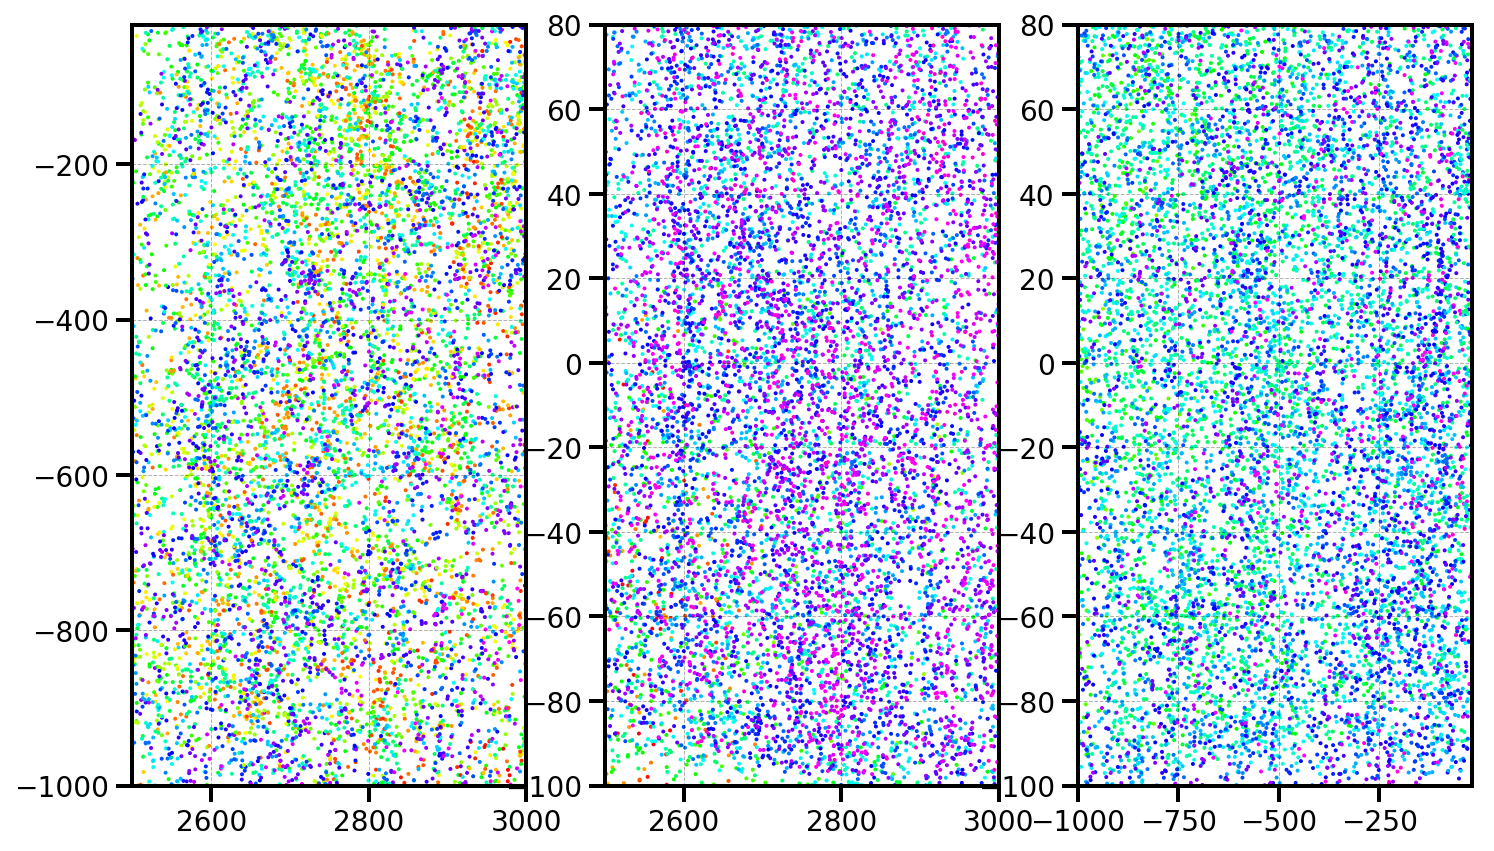

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
#xy
plt.figure(1)
plt.subplot(131)
plt.gca().set_xlim((2500,3000))
plt.gca().set_ylim((-1000,-20))
plt.scatter(x_cart, y_cart, s=1, c=z_cart, cmap='gist_rainbow')
#plt.colorbar()

#xz
plt.subplot(132)
plt.gca().set_xlim((2500,3000))
plt.gca().set_ylim((-100,80))
plt.scatter(x_cart, z_cart, s=1, c=y_cart, cmap='gist_rainbow')
#plt.colorbar()

#yz
plt.subplot(133)
plt.gca().set_xlim((-1000,-20))
plt.gca().set_ylim((-100,80))
plt.scatter(y_cart, z_cart, s=1, c=x_cart, cmap='gist_rainbow')

### Make a mesh file

In [12]:
def Make_mesh(x=np.array(x_cart),y=np.array(y_cart),z=np.array(z_cart),weight = w, N_mesh=26):
    x_max = 3000;x_min = 2500
    y_max = -20;y_min = -1000
    z_max = 80;z_min = -100
    mesh_matrix = np.zeros((N_mesh,N_mesh,N_mesh))
    x_interval = (x_max-x_min)/float(N_mesh)
    y_interval = (y_max-y_min)/float(N_mesh)
    z_interval = (z_max-z_min)/float(N_mesh)
    x_num=0;y_num=0;z_num=0
    for i in range(0,len(x)):
        if x[i]>=2500 and x[i]<3000 and y[i]>=-1000 and y[i]<-20 and z[i]>=-100 and z[i]<80:
            x_num = int((x[i]-x_min)/x_interval)
            y_num = int((y[i]-y_min)/y_interval)
            z_num = int((z[i]-z_min)/z_interval)
            mesh_matrix[x_num][y_num][z_num]+=w[i]
    return mesh_matrix

Mesh_mat = Make_mesh()

In [66]:
import nbodykit.source.mesh.array as Ary
mesh = Ary.ArrayMesh(Mesh_mat,BoxSize=(500,980,180))

### preview mesh on x-y plane

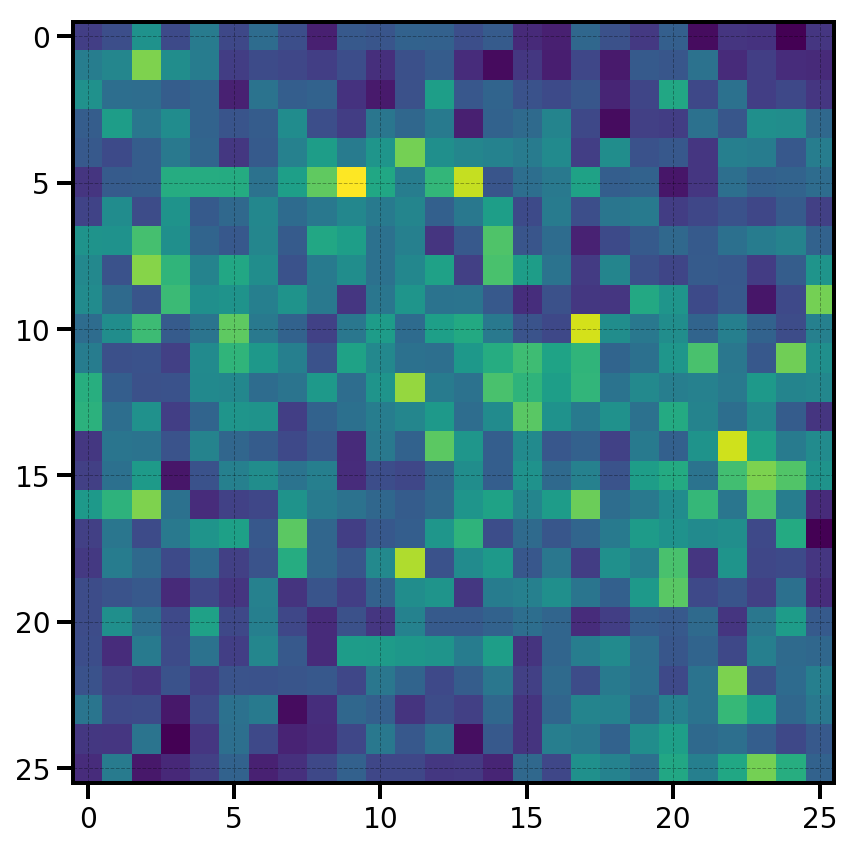

In [15]:
image = mesh.preview(axes=(0, 1))

plt.imshow(image)

### compute the power spectrum with mesh

In [16]:
from nbodykit.algorithms.fftpower import FFTPower
r = FFTPower(mesh,mode='1d',BoxSize=(500,980,180),dk=0.005)

[ 000032.66 ]   0: 03-12 11:51  MeshSource      INFO     field: ArrayMesh() painting done


In [17]:
print(r.power)

<BinnedStatistic: dims: (k: 17), variables: ('k', 'power', 'modes')>


In [18]:
r.power['power']

array([     0.        +0.j,  10420.79719129+0.j, 125772.372669  +0.j,
        16738.63772063+0.j,  11140.36022289+0.j,  14019.5710362 +0.j,
         9948.32446085+0.j,  16578.88166587+0.j,  13463.03765116+0.j,
         9702.11542552+0.j,  14875.02028364+0.j,   6926.29724079+0.j,
         8537.69372452+0.j,   8161.37485188+0.j,   8514.7423337 +0.j,
         7475.86278307+0.j,   7506.97660315+0.j])

Text(0.5,1,'power spectrum of ELGs')

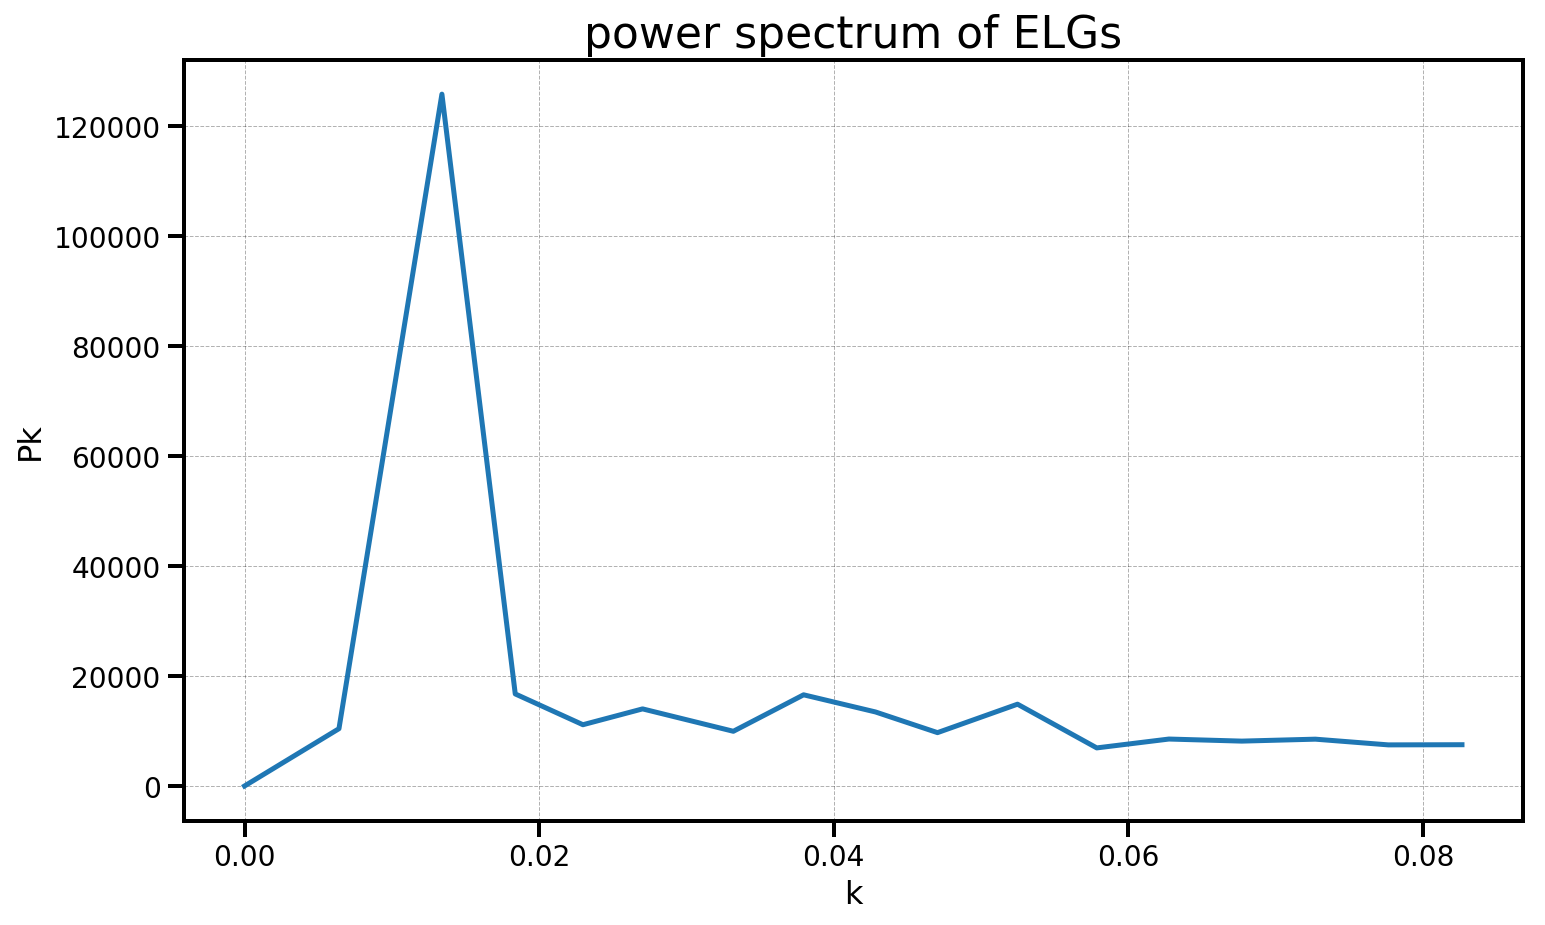

In [71]:
plt.plot(r.power['k'],r.power['power'].real)
plt.xlabel('k')
plt.ylabel('Pk')
plt.title('power spectrum of ELGs')

In [20]:
np.savetxt('powerspec.txt', numpy.array((r.power['k'], r.power['power'].real)).T)

### generate a lot more galaxies and mesh with higher precision with fastPM

In [21]:
%%file nbodykit.lua

nc = 128

boxsize = 500

time_step = linspace(0.1, 1, 10)

output_redshifts= {0.3}  -- redshifts of output

omega_m = 0.307494
h       = 0.6774

read_powerspectrum= "powerspec.txt"
linear_density_redshift = 0.85
random_seed= 100

pm_nc_factor = 2

np_alloc_factor= 4.0      -- Amount of memory allocated for particle

write_snapshot= "fastpm" 
write_nonlineark= "fastpm" 

-- 1d power spectrum (raw), without shotnoise correction
write_powerspectrum = "powerspec-debug"

Overwriting nbodykit.lua


In [22]:
%%bash
export OMP_NUM_THREADS=1
module load impi
mpirun -n 4 /global/homes/h/huikong/.conda/envs/cfastpm/bin/fastpm nbodykit.lua

[ 0000000.0000 ]: This is FastPM, with libfastpm version 1.0.8442714069.
[ 0000000.0020 ]: Configuration {
	boxsize = 500,
	compute_potential = false,
	dealiasing_type = "none",
	dh_factor = 1.0,
	enforce_broadband_kmax = 4,
	f_nl_type = "none",
	force_mode = "fastpm",
	h = 0.677400000000000002,
	inverted_ic = false,
	kernel_type = "3_4",
	kmax_primordial_over_knyquist = 0.25,
	nc = 128,
	np_alloc_factor = 4.0,
	omega_m = 0.30749399999999999,
	painter_support = 2,
	painter_type = "cic",
	pm_nc_factor = 2,
	random_seed = 100,
	read_powerspectrum = "powerspec.txt",
	remove_cosmic_variance = false,
	set_mode_method = "override",
	shift = false,
	sigma8 = 0,
	write_nonlineark = "fastpm",
	write_powerspectrum = "powerspec-debug",
	write_snapshot = "fastpm",
	za = false,
	aout = {
		0.769230769230769162,
	},
	output_redshifts = {
		0.299999999999999989,
	},
	time_step = {
		0.100000000000000006,
		0.190000000000000002,
		0.280000000000000027,
		0.369999999999999996,
		0.459999999999999964,
	

## Mesh at different redshifts
Comparing the mesh at different redshifts, we can see that galaxies from lower redshit from more structure shape. 

### mesh at redshift = 1.4

[ 000123.16 ]   0: 03-12 11:53  CatalogSource   INFO     Extra arguments to FileType: ('fastpm_0.4167',)
[ 000123.16 ]   0: 03-12 11:53  MeshSource      INFO     reading complex field from fastpm_0.4167/


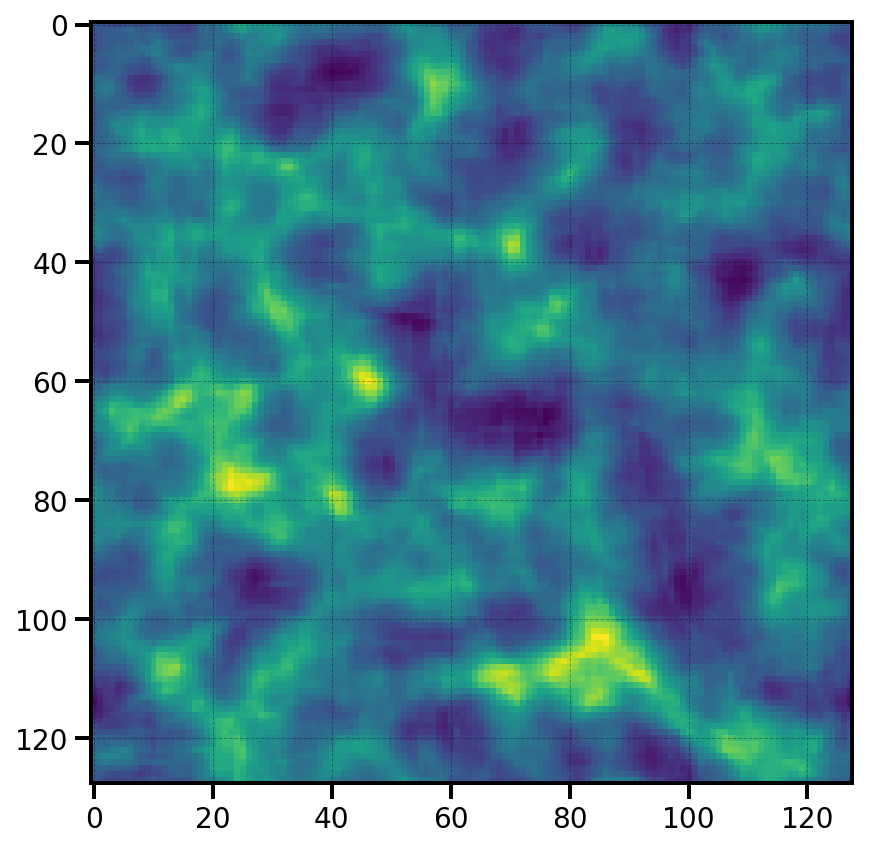

In [25]:
part = BigFileCatalog('fastpm_0.4167', dataset='1/', header='Header')

mesh = BigFileMesh('fastpm_0.4167/', 'DensityK')
image = mesh.preview(axes=(0, 1))
plt.figure(1)
plt.imshow(image)

### mesh at redshift = 0.7

[ 000145.34 ]   0: 03-12 11:53  CatalogSource   INFO     Extra arguments to FileType: ('fastpm_0.5882',)
[ 000145.34 ]   0: 03-12 11:53  MeshSource      INFO     reading complex field from fastpm_0.5882/


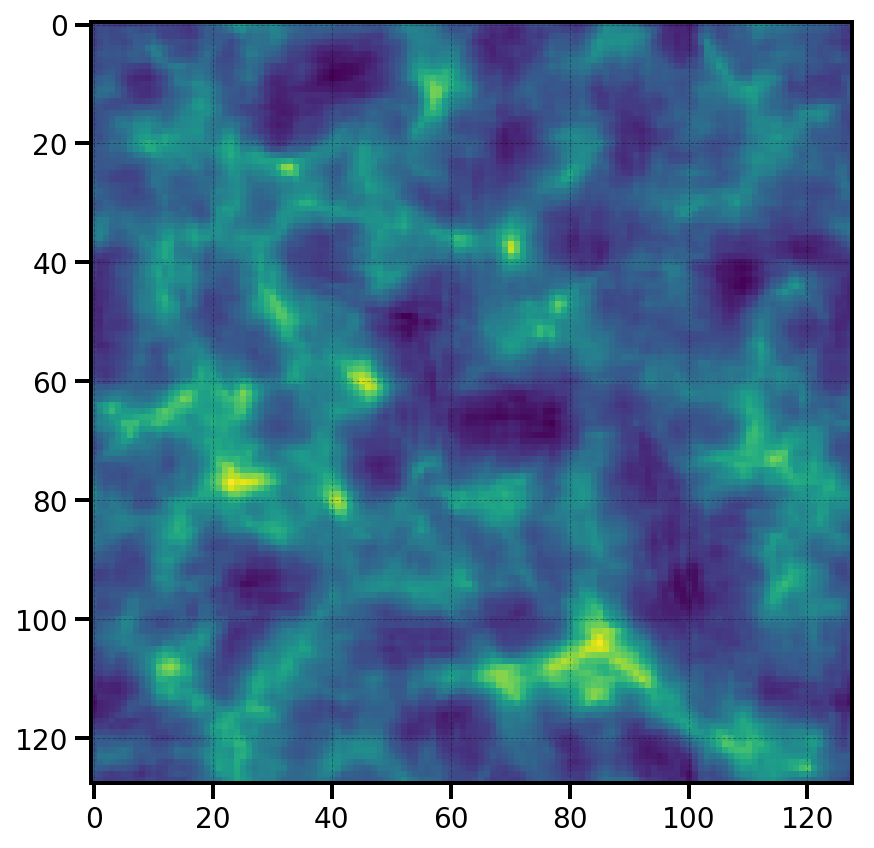

In [26]:
part2 = BigFileCatalog('fastpm_0.5882', dataset='1/', header='Header')
mesh2 = BigFileMesh('fastpm_0.5882/', 'DensityK')
image2 = mesh2.preview(axes=(0, 1))
plt.imshow(image2)

### projection along x axis

In [58]:
x_array = np.array(x_cart)
y_array = np.array(y_cart)
z_array = np.array(z_cart)
position_array = np.array(list(zip(x_array,y_array,z_array)))
list_position = []
for i in range(0,len(position_array)):
    if position_array[i][0]>2500 and position_array[i][0]<3000 and position_array[i][1]>-1000 and position_array[i][1]<-20 and position_array[i][2]>-100 and position_array[i][2]<80:
        list_position.append([position_array[i]])
sub_position = np.array(list_position)

hist_x = mesh2.preview(axes=(0))
hist_y = mesh2.preview(axes=(1))
hist_z = mesh2.preview(axes=(2))

hist_x_input = mesh.preview(axes=(0))

[ 000666.71 ]   0: 03-12 12:02  MeshSource      INFO     reading complex field from fastpm_0.5882/
[ 000666.79 ]   0: 03-12 12:02  MeshSource      INFO     reading complex field from fastpm_0.5882/
[ 000666.89 ]   0: 03-12 12:02  MeshSource      INFO     reading complex field from fastpm_0.5882/


### Data Validation
The blue one is the input mesh

The green one is the real data

The red one the simualtion mesh

We can see that the data are quite noisy now. That's because the dataset of ELGs are very small. With more data ihe future, we will have less noise in such distribution. 

/global/homes/h/huikong/.conda/envs/cfastpm/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


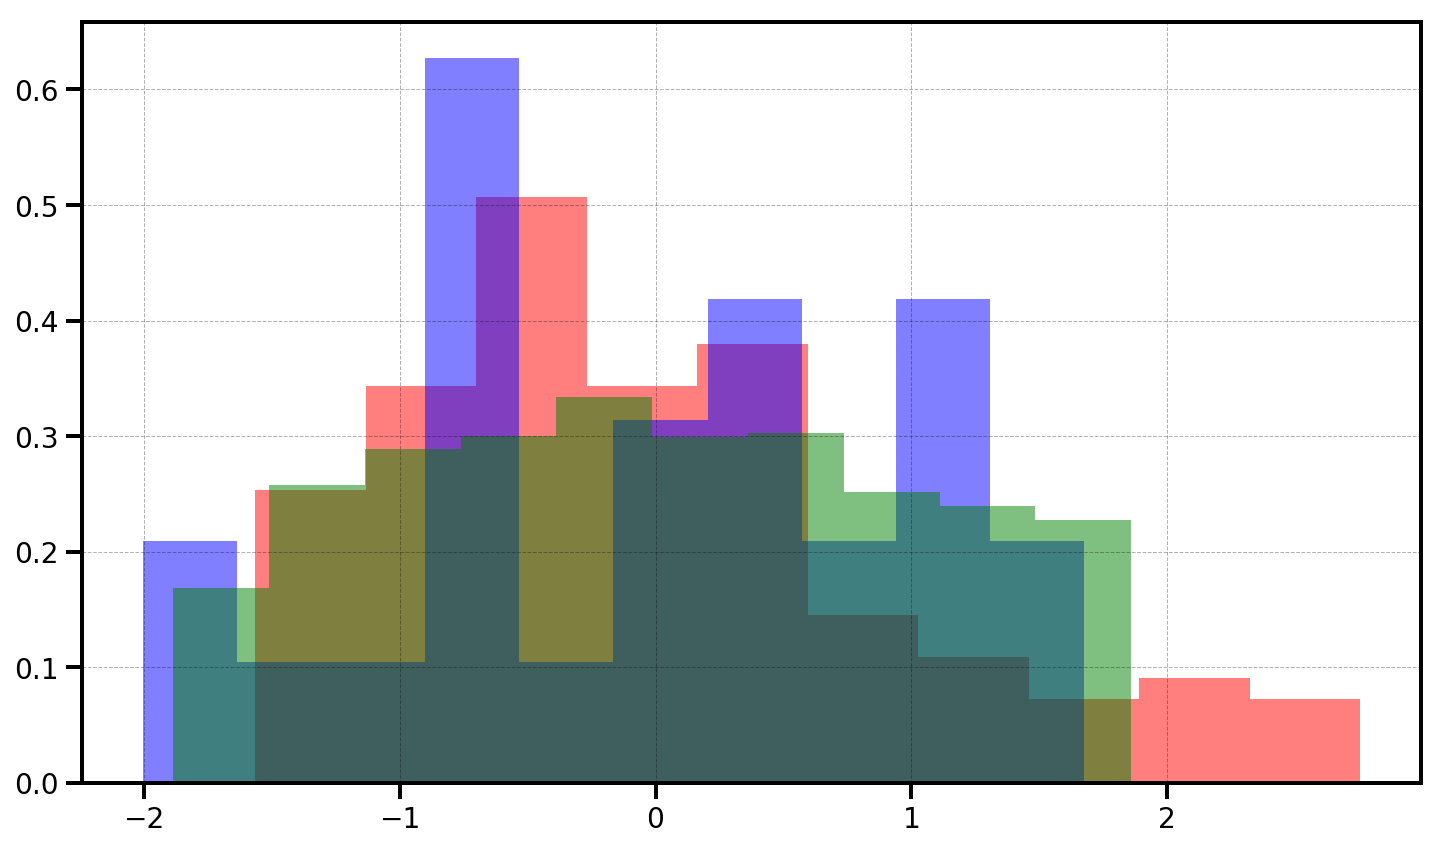

In [68]:
plt.hist((np.array(hist_x)-np.mean(np.array(hist_x)))/np.std(np.array(hist_x)),normed=True,alpha=0.5,color = 'r')
plt.hist((np.array(hist_x_input)-np.mean(np.array(hist_x_input)))/np.std(np.array(hist_x_input)),normed=True,alpha=0.5,color = 'b')
plt.hist((sub_position.transpose()[0][0]-np.mean(sub_position.transpose()[0][0]))/np.std(sub_position.transpose()[0][0]),normed=True,alpha=0.5,color = 'g')
plt.show()

### Correlation Function
We can also do a correlation function between the real data and the galaxies data. (If time permitted for me...)